In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import os
import pims
import cv2
from scipy import interpolate
import skimage.filters as sk_fil
import imutils
from skimage.transform import rotate
import sys
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')
import myAnalyses.lowmag_analysis_OSS as dio

In [9]:
path_forStabilisation = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/filamentsToAnalyse/23-12-06_2_FilamentF_1_650_pos1_forStabilisation/'
path_to_image_stack_forStabilisation = path_forStabilisation + r'*.tif'

path_imageToBeStabilised = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/filamentsToAnalyse/23-12-06_2_FilamentF_775_1555_pos1/'
path_to_image_stack_imageToBeStabilised = path_imageToBeStabilised + r'*.tif'

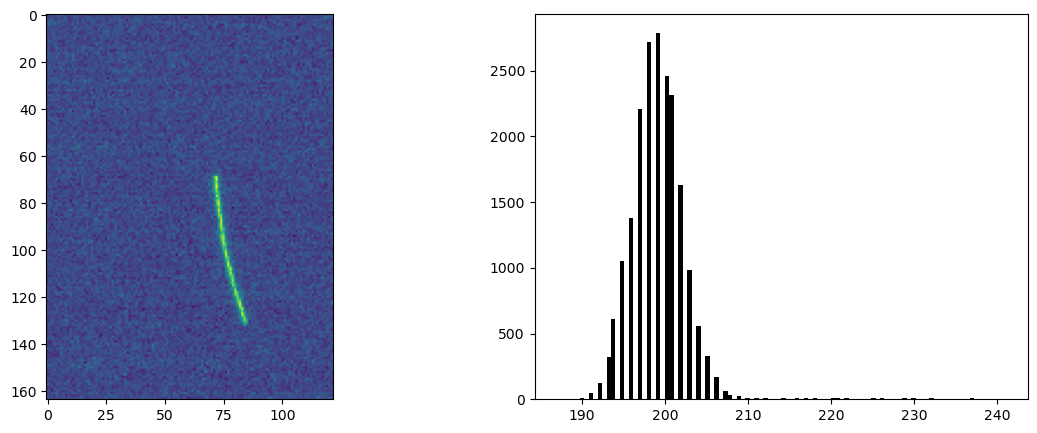

dtype('uint8')

In [10]:

#open image stack
frames = pims.open(path_to_image_stack_forStabilisation)

#convert image datatype, first to float to normalise and then to uint8
#first get max pixel value
k=0
maxPixel=0
for frame in frames:
    intPixel = max(frame.flat)
    if intPixel>maxPixel:
        maxPixel=intPixel
        frameID = k
    k=k+1

#maxPixelValue = np.iinfo(frames[120].dtype).max             #get max allowed pixel value
frames1 = pims.pipeline(lambda x: x.astype(np.float32))(frames) #convert to float32 first
frames2 = pims.pipeline(lambda x: x*(255/maxPixel))(frames1) #normalize to 0-255 range
frames3 = pims.pipeline(lambda x: x.astype(np.uint8))(frames2)  #convert to uint8 
frames = frames3

# Plot a test frame and show the histogram
fig, ax = plt.subplots(1,2, figsize=(14,5))
frame = frames[22]
#ax[0].imshow(frame, vmin=0, vmax=1, cmap='Reds')
ax[0].imshow(frame)
n_0, bins_0, patches_0 = ax[1].hist(frame.flat, bins = 100, color='black')
plt.show()
#frames3
frame[22].dtype




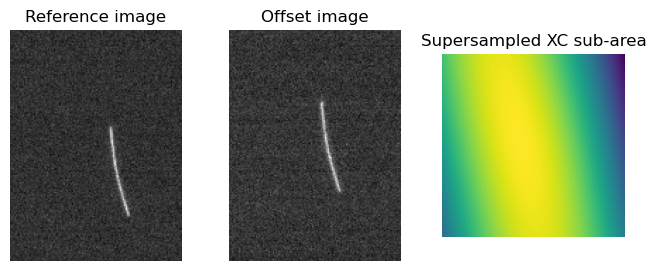

Detected subpixel offset (y, x): [17.55  5.63]
Detected subpixel offset per image (y, x): [0.027      0.00866154]


In [11]:
#the following is implemented here:
#https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_translation.html

from skimage.registration._phase_cross_correlation import _upsampled_dft
from skimage.registration import phase_cross_correlation

frame1 = frames[0]
frame2 = frames[-1]

# subpixel precision
shift, error, diffphase = phase_cross_correlation(frame1, frame2,
                                                  upsample_factor=100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(frame1, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(frame2.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
image_product = np.fft.fft2(frame1) * np.fft.fft2(frame2).conj()
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Detected subpixel offset (y, x): {shift}')
print(f'Detected subpixel offset per image (y, x): {shift/len(frames)}')
shiftToApply = -1*shift/len(frames)

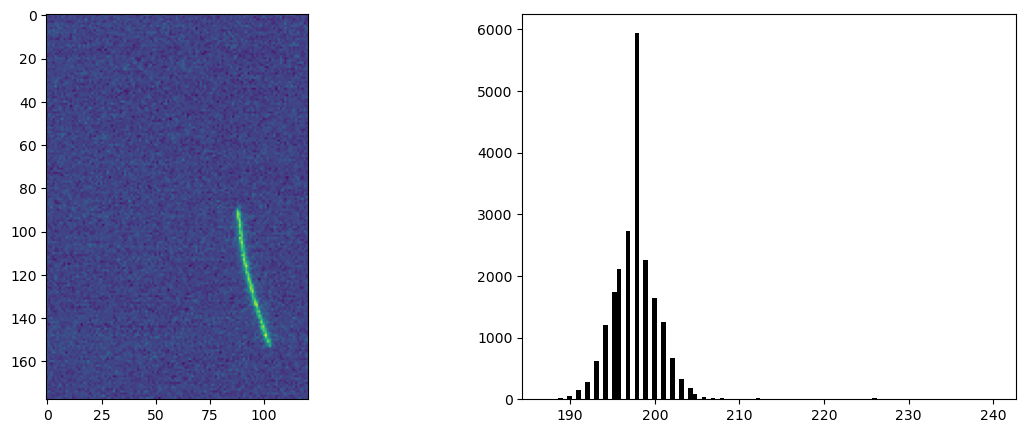

dtype('uint8')

In [12]:


#open image stack
frames = pims.open(path_to_image_stack_imageToBeStabilised)

#convert image datatype, first to float to normalise and then to uint8
#first get max pixel value
k=0
maxPixel=0
for frame in frames:
    intPixel = max(frame.flat)
    if intPixel>maxPixel:
        maxPixel=intPixel
        frameID = k
    k=k+1

#maxPixelValue = np.iinfo(frames[120].dtype).max             #get max allowed pixel value
frames1 = pims.pipeline(lambda x: x.astype(np.float32))(frames) #convert to float32 first
frames2 = pims.pipeline(lambda x: x*(255/maxPixel))(frames1) #normalize to 0-255 range
frames3 = pims.pipeline(lambda x: x.astype(np.uint8))(frames2)  #convert to uint8 
frames = frames3

# Plot a test frame and show the histogram
fig, ax = plt.subplots(1,2, figsize=(14,5))
frame = frames[22]
#ax[0].imshow(frame, vmin=0, vmax=1, cmap='Reds')
ax[0].imshow(frame)
n_0, bins_0, patches_0 = ax[1].hist(frame.flat, bins = 100, color='black')
plt.show()
#frames3
frame[22].dtype


In [13]:
from scipy.ndimage import fourier_shift
from skimage import transform
from skimage import img_as_float

pathToSave = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/filamentsToAnalyse/try/'

#tform = transform.EuclideanTransform(
#    rotation=0,
#    translation = (-1*shift[0]/len(frames), -1*shift[1]/len(frames))
#    )

framesNew = np.copy(frames)
#framesNew=[]

for i in range(0,len(frames)):
    #frame = img_as_float(frames[i])
    frame = frames[i]
    #tform = transform.EuclideanTransform(
    #    rotation=0,
    #    translation = (i*shiftToApply[0], i*shiftToApply[1])
    #    )
    #tf_img = transform.warp(frame, tform.inverse)
    # The shift corresponds to the pixel offset relative to the reference image
    offset_image = fourier_shift(np.fft.fftn(frame), -1*i*shiftToApply)
    #offset_image = fourier_shift(np.fft.fftn(frame), i*shiftToApply)
    offset_image = np.fft.ifftn(offset_image)
    framesNew[i] = offset_image.real
    #framesNew[i] = tf_img
    #framesNew = np.append(framesNew,tf_img)
    cv2.imwrite(os.path.join(pathToSave , 'imStabilised_'+str(i)+'.tif'), framesNew[i])
    #cv2.imwrite(os.path.join(pathToSave , 'imStabilised_'+str(i)+'.tif'), tf_img)

print(f'Shift applied per image (y, x): {shiftToApply}')
print(f'Shift applied to last image (y, x): {i*shiftToApply}')
#print(tform.params)

Shift applied per image (y, x): [-0.027      -0.00866154]
Shift applied to last image (y, x): [-21.06   -6.756]
